#Import Libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import quantile_transform
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


#Data Exploration

In [10]:
Ny_Home_Df = pd.read_csv('Sensors.csv')
Ny_Home_Df.drop(Ny_Home_Df.tail(1).index,inplace=True) #remove the last row
Ny_Home_Df.columns = [col.replace(' [kW]', '') for col in Ny_Home_Df.columns]
Ny_Home_Df['All_Furnace'] = Ny_Home_Df[['Furnace 1','Furnace 2']].sum(axis=1)
Ny_Home_Df['All_Kitchen'] = Ny_Home_Df[['Kitchen 12','Kitchen 14','Kitchen 38']].mean(axis=1)
Ny_Home_Df = Ny_Home_Df.drop(['icon', 'summary','gen','cloudCover','time','Kitchen 12', 'Kitchen 14', 'Kitchen 38', 'Furnace 1', 'Furnace 2'], axis=1)
time_index = pd.date_range('2016-01-01 05:00', periods=len(Ny_Home_Df), freq='min')  
time_index = pd.DatetimeIndex(time_index)
Ny_Home_Df = Ny_Home_Df.set_index(time_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
features = ['temperature','humidity', 'visibility','apparentTemperature','windSpeed', 'pressure', 'windBearing', 'precipIntensity','dewPoint','precipProbability']
targets = ['use','Dishwasher','Home office','Fridge','Wine cellar','Garage door','Barn','Well','Microwave','Living room','Solar', 'All_Furnace' ,'All_Kitchen']
df = Ny_Home_Df[targets].resample('H').sum()
df1 = Ny_Home_Df[features].resample('H').mean()
df_hr = pd.concat([df, df1], axis=1)
df_hr.head()

,use,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Solar,All_Furnace,All_Kitchen,temperature,humidity,visibility,apparentTemperature,windSpeed,pressure,windBearing,precipIntensity,dewPoint,precipProbability
2016-01-01 05:00:00,62.647783,0.003817,14.508850,2.271667,3.801033,0.782767,2.332833,0.062533,1.299100,0.090283,0.198417,23.591283,0.016411,36.131000,0.619667,10.0,29.264667,9.150333,1016.888,282.100000,0.0,24.383333,0.0
2016-01-01 06:00:00,55.090017,0.005950,2.597617,4.531317,6.776500,0.770167,2.350883,0.061250,0.252967,0.097083,0.205300,27.402450,0.014972,35.838667,0.610000,10.0,29.364667,8.284000,1016.232,284.733333,0.0,23.866000,0.0
2016-01-01 07:00:00,42.884167,0.002550,2.604967,3.569133,0.431050,0.797917,2.066350,0.060833,0.254733,0.097717,0.206900,22.330200,0.014528,35.385000,0.613000,10.0,29.034000,7.927000,1015.989,279.400000,0.0,23.469000,0.0
2016-01-01 08:00:00,57.600767,0.008300,3.900833,3.624717,0.422683,0.775517,2.051700,0.060983,0.256450,0.098067,0.206850,36.982217,0.016111,35.282000,0.640000,10.0,30.395333,5.684667,1016.042,265.000000,0.0,24.202667,0.0
2016-01-01 09:00:00,38.390183,0.003617,2.603500,2.106350,0.428567,0.793200,1.909783,0.060817,0.255467,0.099000,0.206350,20.630550,0.015917,35.451667,0.641667,10.0,29.673333,6.975000,1015.815,265.500000,0.0,24.423333,0.0


In [42]:
df_hr.describe()

,use,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Solar,All_Furnace,All_Kitchen,temperature,humidity,visibility,apparentTemperature,windSpeed,pressure,windBearing,precipIntensity,dewPoint,precipProbability
count,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000
mean,51.534676,1.881939,4.876923,3.813158,2.528048,0.848297,3.511565,0.938465,0.658940,2.118642,4.573493,14.158526,0.195745,50.741005,0.664097,9.253414,48.262262,6.649940,1016.301339,202.355870,0.002599,38.693571,0.056480
std,48.398038,7.136702,5.619182,2.622486,2.840209,0.359387,6.370624,2.062920,2.159726,4.902443,7.428225,12.201422,0.532215,19.096105,0.193418,1.589102,22.004686,3.922501,7.891495,100.930971,0.010823,19.082478,0.161169
min,0.048000,0.000000,0.004998,0.006000,0.001002,0.003000,0.004998,0.000000,0.000000,0.000000,0.013000,0.018002,0.000000,-12.589000,0.130000,0.283333,-31.354667,0.168000,986.482333,0.000000,0.000000,-27.170333,0.000000
25%,25.775450,0.000418,2.436692,2.132825,0.439200,0.767083,1.810617,0.059450,0.233142,0.090783,0.201983,5.216475,0.013539,35.784000,0.514917,9.406333,31.056667,3.670167,1011.314083,152.958333,0.000000,24.535083,0.000000
50%,40.558717,0.002667,2.550317,3.380300,0.866033,0.778117,1.929733,0.060367,0.239983,0.097983,0.258433,7.501433,0.015039,50.341000,0.681333,9.997833,50.111667,5.900000,1016.535667,207.083333,0.000000,38.970667,0.000000
75%,61.007775,0.010292,4.536300,4.894092,4.509825,0.789875,2.193458,0.065958,0.246442,0.116583,5.484800,20.746417,0.018089,66.300917,0.835333,10.000000,66.300917,8.888500,1021.475667,290.591667,0.000000,54.801583,0.000000
max,574.811067,49.475367,39.994233,23.459183,46.992567,17.666050,108.786283,31.924767,40.893600,21.482917,32.710450,70.653717,5.307839,93.503667,0.980000,10.000000,100.930667,22.674000,1042.433333,358.833333,0.179407,75.425333,0.838667


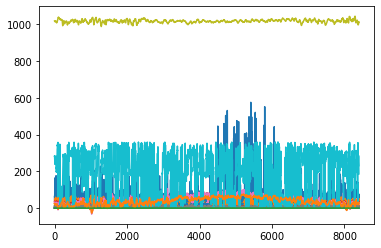

In [14]:
training_set = df_hr.iloc[:,:].values
plt.plot(training_set)
plt.show()

#Data Preprocessing

In [116]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 24
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size]))).to(device)
trainY = Variable(torch.Tensor(np.array(y[0:train_size]))).to(device)

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)]))).to(device)
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]))).to(device)

#Models

In [20]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

#Training

In [117]:
num_epochs = 5500
learning_rate = 0.001

input_size = 23
hidden_size = 20
num_layers = 1

num_classes = 23

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm = lstm.to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
loss_ = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    loss_.append(loss)
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.19654
Epoch: 100, loss: 0.02189
Epoch: 200, loss: 0.01780
Epoch: 300, loss: 0.01536
Epoch: 400, loss: 0.01274
Epoch: 500, loss: 0.01075
Epoch: 600, loss: 0.00953
Epoch: 700, loss: 0.00891
Epoch: 800, loss: 0.00850
Epoch: 900, loss: 0.00820
Epoch: 1000, loss: 0.00796
Epoch: 1100, loss: 0.00776
Epoch: 1200, loss: 0.00759
Epoch: 1300, loss: 0.00744
Epoch: 1400, loss: 0.00731
Epoch: 1500, loss: 0.00720
Epoch: 1600, loss: 0.00711
Epoch: 1700, loss: 0.00703
Epoch: 1800, loss: 0.00697
Epoch: 1900, loss: 0.00692
Epoch: 2000, loss: 0.00688
Epoch: 2100, loss: 0.00684
Epoch: 2200, loss: 0.00680
Epoch: 2300, loss: 0.00676
Epoch: 2400, loss: 0.00673
Epoch: 2500, loss: 0.00670
Epoch: 2600, loss: 0.00668
Epoch: 2700, loss: 0.00665
Epoch: 2800, loss: 0.00663
Epoch: 2900, loss: 0.00660
Epoch: 3000, loss: 0.00658
Epoch: 3100, loss: 0.00656
Epoch: 3200, loss: 0.00654
Epoch: 3300, loss: 0.00652
Epoch: 3400, loss: 0.00650
Epoch: 3500, loss: 0.00648
Epoch: 3600, loss: 0.00645
Epoch: 3700, 

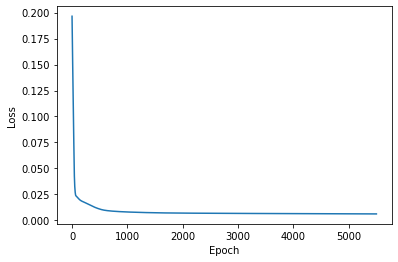

In [118]:
plt.plot(loss_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Save the trained model
PATH = './lstm_withWeather.pth'
torch.save(lstm.state_dict(), PATH)

#Testing

In [ ]:
input_size = 18
hidden_size = 8
num_layers = 1

num_classes = 18

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
PATH_lstm = './lstm_EnergyPre.pth'
lstm.load_state_dict(torch.load(PATH_lstm))

In [119]:
lstm.eval()
test_predict = lstm(testX)
data_predict = test_predict.data.cpu().detach().numpy()
dataY_plot = testY.data.cpu().detach().numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testY.cpu().detach().numpy())

from sklearn.metrics import mean_squared_error
MAE = np.mean(np.abs([data_predict[j]-dataY_plot[j] for j in range(len(data_predict))]))
RMSE = np.sqrt(mean_squared_error(data_predict,dataY_plot))
MSE = mean_squared_error(data_predict,dataY_plot) 
print('MAE is', MAE, 'MSE is', MSE, 'RMSE is', RMSE)

MAE is 3.3532739 MSE is 185.25618 RMSE is 13.610885


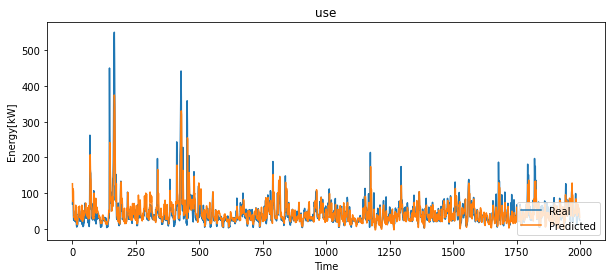

In [120]:
feature = 0
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

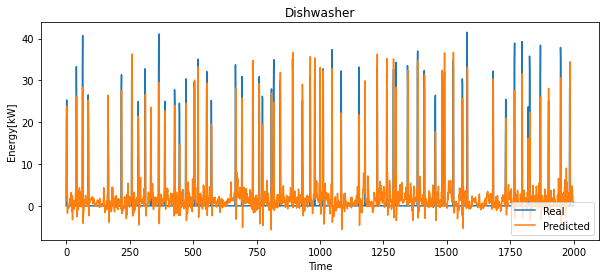

In [121]:
feature = 1
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

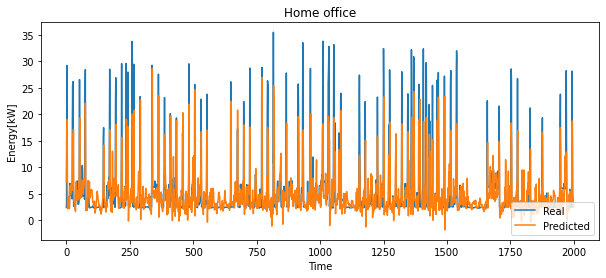

In [122]:
feature = 2
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

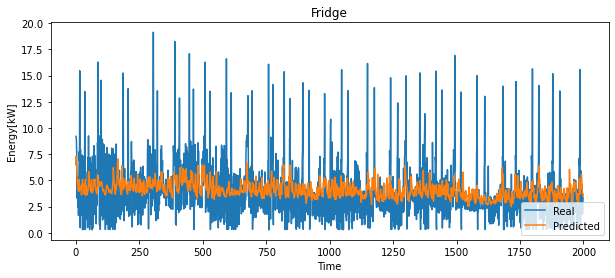

In [123]:
feature = 3
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

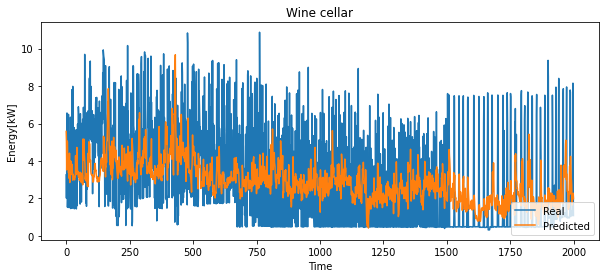

In [124]:
feature = 4
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

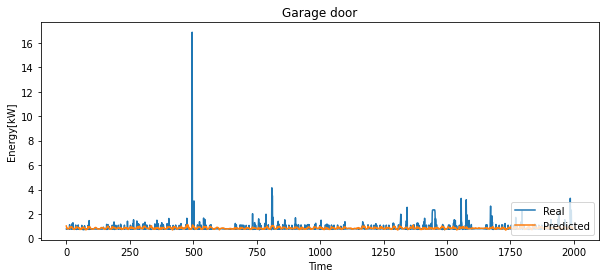

In [125]:
feature = 5
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

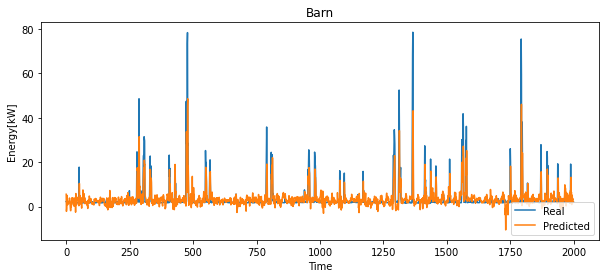

In [126]:
feature = 6
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

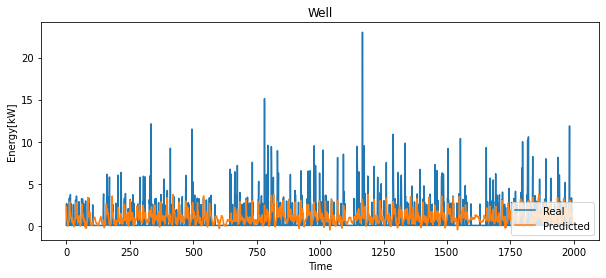

In [127]:
feature = 7
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

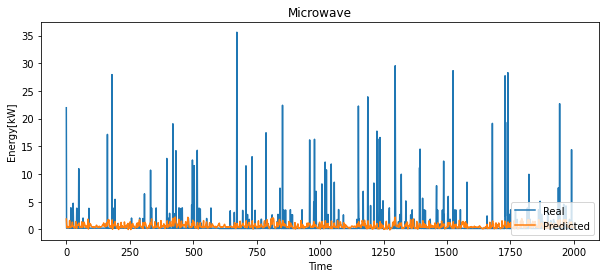

In [128]:
feature = 8
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

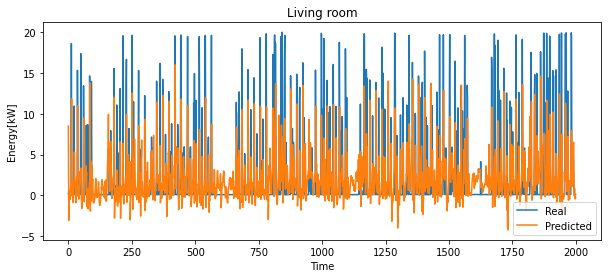

In [129]:
feature = 9
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

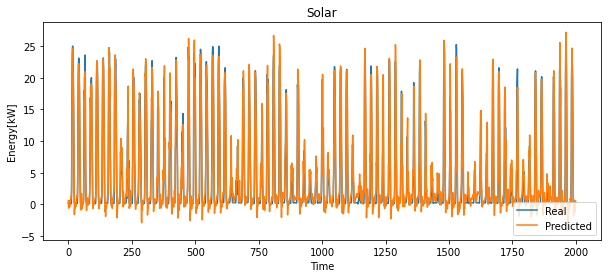

In [130]:
feature = 10
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

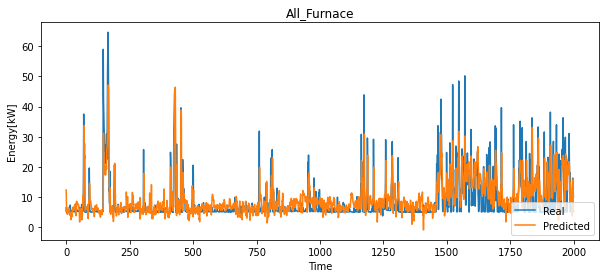

In [131]:
feature = 11
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()

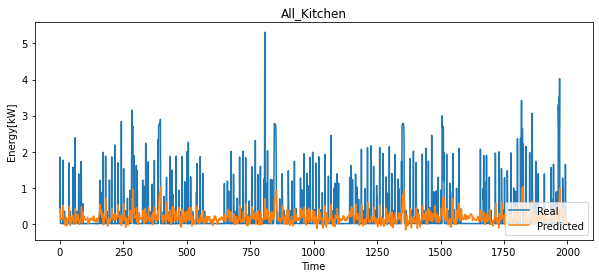

In [132]:
feature = 12
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()